# Parser

In [1]:
# backend/sitemap_parser.py
from bs4 import BeautifulSoup
import requests
from urllib.parse import urlparse, urlunparse

HEADERS = {"User-Agent": "Mozilla/5.0"}

In [2]:
def normalize_url(url: str) -> str:
    url = url.lower().strip() # Remove leading/trailing whitespace and convert to lowercase
    if not url.startswith("http"):
        url = "https://" + url
    
    if url.startswith("https://") and not url.startswith("https://www."):
        url = url.replace("https://", "https://www.", 1)
    elif not url.startswith("https://www."):
        url = "https://www." + url
    
    parsed = urlparse(url)

    # Normalize to scheme + netloc only (strip path, params, query, fragment)
    normalized_url = urlunparse((parsed.scheme, parsed.netloc, '', '', '', ''))
    return normalized_url

print(f"Normalized URL: {normalize_url("nortlightai.com")}")
print(f"Normalized URL: {normalize_url("www.nortlightai.com")}")
print(f"Normalized URL: {normalize_url("https://www.nortlightai.com")}")
print(f"Normalized URL: {normalize_url("https://nortlightai.com")}")
print(f"Normalized URL: {normalize_url("https://nortlightai.com/")}")
print(f"Normalized URL: {normalize_url("https://nortlightai.com/content")}")

Normalized URL: https://www.nortlightai.com
Normalized URL: https://www.nortlightai.com
Normalized URL: https://www.nortlightai.com
Normalized URL: https://www.nortlightai.com
Normalized URL: https://www.nortlightai.com
Normalized URL: https://www.nortlightai.com


In [3]:
def fetch_sitemap(url): # Fetch each xml sitemap in one layer.
    try:
        response = requests.get(url, headers=HEADERS, timeout=5)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'lxml-xml')
        return [loc.text for loc in soup.find_all('loc')]
    except Exception as e:
        print(f"Error: {e}")
        return []
print(f"Fetched Sitemap: {fetch_sitemap('https://northlightai.com/sitemap.xml')}") # This should receive .xml URLs
print(f"Fetched Sitemap: {fetch_sitemap('https://northlightai.com')}")

Fetched Sitemap: ['https://northlightai.com/sitemap.website.xml', 'https://northlightai.com/sitemap.blog.xml', 'https://northlightai.com/sitemap.ols.xml']
Fetched Sitemap: []


In [4]:
def parse_sitemap(url): # Parse the sitemap and return a dictionary of URLs. Applies fetch_sitemap to each xml sitemap layer by layer.
    locs = fetch_sitemap(url)
    if not locs:
        return {url: []}
    
    tree = {}
    urls = []

    for loc in locs:
        if loc.endswith('.xml'):
            tree[loc] = parse_sitemap(loc)
        else:
            urls.append(loc)

    if tree and urls:
        tree["_final_urls"] = urls
        return tree
    elif urls:
        return urls
    else:
        return {url: tree}
print(f"Parsed Sitemap: {parse_sitemap('https://northlightai.com/sitemap.xml')}") # This should receive .xml URLs
print(f"Parsed Sitemap: {parse_sitemap('https://northlightai.com')}")

Parsed Sitemap: {'https://northlightai.com/sitemap.xml': {'https://northlightai.com/sitemap.website.xml': ['https://northlightai.com/publications', 'https://northlightai.com/faq', 'https://northlightai.com/our-customers-1', 'https://northlightai.com/', 'https://northlightai.com/ai-strategic-consulting', 'https://northlightai.com/ai-innovation-lab', 'https://northlightai.com/our-team', 'https://northlightai.com/higher-education', 'https://northlightai.com/product-development', 'https://northlightai.com/north-light-values', 'https://northlightai.com/ai-training-%26-development-1', 'https://northlightai.com/technical-partners', 'https://northlightai.com/ai-literacy-sponsorships', 'https://northlightai.com/m/login', 'https://northlightai.com/m/reset', 'https://northlightai.com/m/create', 'https://northlightai.com/m/create-account'], 'https://northlightai.com/sitemap.blog.xml': ['https://northlightai.com/publications/f/north-light-ai-partners-with-unh-to-launch-affordable-ai-training', 'htt

In [5]:
def extract_final_urls(url): # List all URLs in the sitemap.
    
    url = normalize_url(url)
    final_urls = [url]
    if not url.endswith('/sitemap.xml'):
        url += '/sitemap.xml'
    tree = parse_sitemap(url)
    

    def _walk_tree(node):
        if isinstance(node, dict):
            for key, value in node.items():
                if key == "_final_urls" and isinstance(value, list):
                    final_urls.extend(value)
                else:
                    _walk_tree(value)
        elif isinstance(node, list):
            final_urls.extend([v for v in node if not v.endswith('.xml')])

    _walk_tree(tree)

    
    return final_urls, tree

print(f"Final URLs: {extract_final_urls('https://northlightai.com')[0]}")
print(f"Final URLs: {extract_final_urls('https://www.northlightai.com/')[0]}")
print(f"Final URLs: {extract_final_urls('https://northlightai.com/sitemap.xml')[0]}")

print(f"There are {len(extract_final_urls('https://northlightai.com/sitemap.xml')[0])} links ready to be scraped.")

# The outout here is an input for the scraper or the visualizer.

Final URLs: ['https://www.northlightai.com', 'https://northlightai.com/publications', 'https://northlightai.com/faq', 'https://northlightai.com/our-customers-1', 'https://northlightai.com/', 'https://northlightai.com/ai-strategic-consulting', 'https://northlightai.com/ai-innovation-lab', 'https://northlightai.com/our-team', 'https://northlightai.com/higher-education', 'https://northlightai.com/product-development', 'https://northlightai.com/north-light-values', 'https://northlightai.com/ai-training-%26-development-1', 'https://northlightai.com/technical-partners', 'https://northlightai.com/ai-literacy-sponsorships', 'https://northlightai.com/m/login', 'https://northlightai.com/m/reset', 'https://northlightai.com/m/create', 'https://northlightai.com/m/create-account', 'https://northlightai.com/publications/f/north-light-ai-partners-with-unh-to-launch-affordable-ai-training', 'https://northlightai.com/publications/f/openais-new-o1-strawberry-model-released', 'https://northlightai.com/pub

# Scraper

In [6]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
import time


HEADERS = {"User-Agent": "Mozilla/5.0"}

def scrape(url):
    try:
        response = requests.get(url, headers=HEADERS, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')
        text = soup.get_text(separator=' ', strip=True)
        if text:
            return text
    except:
        pass

    try:
        options = Options()
        options.add_argument('--headless')
        options.add_argument('--disable-gpu')
        options.add_argument('--no-sandbox')
        driver = webdriver.Chrome(options=options)
        driver.get(url)
        time.sleep(3)
        elems = driver.find_elements(By.TAG_NAME, "p")
        text = ' '.join(elem.text for elem in elems).strip()
        driver.quit()
        return text
    except:
        return ""
    
text = scrape("https://northlightai.com")
print(f"Scraped text: {text[:100]}...")  # Print the first 100 characters of the scraped text
print(f"len(text): {len(text)} characters")

# The output here is an input for the RAG model.

Scraped text: AI Strategic Consulting Services | North Light AI Home Our Services AI Training & Development AI Lit...
len(text): 2972 characters


# Visualizer

In [7]:
import networkx as nx
from pyvis.network import Network
import json

def tree_to_edges(tree, parent=None):
    edges = []
    if isinstance(tree, list):
        for item in tree:
            edges.append((parent, item))
    elif isinstance(tree, dict):
        for key, value in tree.items():
            if parent:
                edges.append((parent, key))
            edges += tree_to_edges(value, parent=key)
    return edges

def generate_graph(sitemap_url, output_file="sitemap_network.html", json_filename=None):
    tree = parse_sitemap(sitemap_url)

    # Default name if not provided
    if json_filename is None:
        json_filename = "sitemap_tree.json"

    with open(json_filename, "w", encoding="utf-8") as f:
        json.dump(tree, f, indent=2)

    edges = tree_to_edges(tree[sitemap_url], parent=sitemap_url)

    G = nx.DiGraph()
    G.add_edges_from(edges)
    net = Network(height="750px", width="100%", directed=True, notebook=False)

    for node in G.nodes():
        if node == sitemap_url:
            net.add_node(node, label=str(urlparse(sitemap_url).netloc), title=node, shape='dot', size=30,
                         color={"background": "white", "border": "blue"}, borderWidth=4,
                         font={"color": "black", "size": 35, "bold": True})
        elif node.endswith('.xml'):
            net.add_node(node, label="Sitemap", title=node, shape='dot', size=25)
        else:
            net.add_node(node, label=" ", title=node, shape='dot', size=15,
                         color={"background": "#ccffcc", "border": "#009933"})

    for source, target in G.edges():
        net.add_edge(source, target)

    net.force_atlas_2based()
    net.set_options("""
    { "physics": { "stabilization": false }, "interaction": { "dragNodes": true } }
    """)
    net.write_html(output_file)

    # Read the generated HTML
    with open(output_file, "r", encoding="utf-8") as f:
        html = f.read()

    # Inject JS
    inject_js = f"""
    <script type="text/javascript">
    window.addEventListener("load", function () {{
        // ✅ Hide the Pyvis loading bar if it exists
        const loader = document.getElementById("loadingBar");
        if (loader) loader.style.display = "none";

        const rootNodeId = "{sitemap_url}";
        const titleNodeId = "graph_title";
        const originalLabels = {{}};

        network.on("click", function (params) {{
        if (params.nodes.length > 0) {{
            let clickedNodeId = params.nodes[0];

            nodes.get().forEach(function (node) {{
            if (!(node.id in originalLabels)) {{
                originalLabels[node.id] = node.label;
            }}

            if (node.id === rootNodeId || node.id === titleNodeId) {{
                return;
            }}

            if (node.id === clickedNodeId) {{
                nodes.update({{id: node.id, label: node.title}});
            }} else {{
                nodes.update({{id: node.id, label: ""}});
            }}
            }});
        }} else {{
            nodes.get().forEach(function (node) {{
            if (node.id !== rootNodeId && node.id !== titleNodeId && originalLabels[node.id] === "") {{
                nodes.update({{id: node.id, label: ""}});
            }}
            }});
        }}
        }});
    }});
    </script>
    """

    # Inject before </body>
    html = html.replace("</body>", inject_js + "\\n</body>")

    # Save it back
    with open(output_file, "w", encoding="utf-8") as f:
        f.write(html)
    print(f"Output files successfully generated: {output_file} and {json_filename}")
    return output_file

sitemap_url = 'https://northlightai.com/sitemap.xml' # This should receive .xml URLs
output_file = generate_graph(sitemap_url, output_file="output/sitemap_network.html", json_filename="output/sitemap_tree.json")



Output files successfully generated: output/sitemap_network.html and output/sitemap_tree.json


# RAG model (using Langchain)
## Step 1) Indexing

In [8]:
import getpass
import os
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
else:
  print(f"Openai API key successfully imported from .env file.")
  #print(f"Key: {os.environ.get('OPENAI_API_KEY')}")

Openai API key successfully imported from .env file.


### Setup

In [9]:
# Chat Model
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

# Embedding Model
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Vector Store-In memory
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

# Vector Store-Supabase
from langchain_community.vectorstores import SupabaseVectorStore
from langchain_openai import OpenAIEmbeddings  # or any other embedding model
from supabase import create_client, Client

# Initialize Supabase client

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Create or connect to Supabase vector store
vector_store = SupabaseVectorStore(
    client=supabase,
    embedding=embeddings,
    table_name="prime_ready.webcontent",  # You can change this
    query_name="prime_ready.match_documents"  # Needs to be created in Supabase SQL
)


### Loading

In [10]:
from langchain_core.documents import Document  # Core document class
# Load content from scraped web pages
company_name = "Northlight AI"
website = "https://northlightai.com"
link = "https://northlightai.com"
text = scrape(link)

print(f"Scraped text: {text[:100]}...")  # Print the first 100 characters of the scraped text
print(f"len(text): {len(text)} characters")

url = normalize_url(website)

if not url.endswith('/sitemap.xml'):
    url += '/sitemap.xml'
tree = parse_sitemap(url)

# Add company into company table in Supabase
company_id = supabase.rpc("insert_company", {
    "company_name": company_name,
    "link": website,  # ✅ must match SQL function param name
    "sitemap": json.dumps(tree)  # Add the sitemap data
}).execute().data

print(f"✅ Company ID: {company_id}")

# Create metadata and document content
metadata={
        "source": str(link),
        "website": str(website),
        "company_id": str(company_id)
    }

docs = Document(
    page_content=text,
    metadata=metadata
)

print("==" * 20)

print(f"Scraped and converted to LangChain Document.")
print(f"Document preview: {docs.page_content[:100]}...")
print(f"Metadata: {docs.metadata}")

Scraped text: AI Strategic Consulting Services | North Light AI Home Our Services AI Training & Development AI Lit...
len(text): 2972 characters
✅ Company ID: eec31547-8111-4414-b1b0-0d4778bb3302
Scraped and converted to LangChain Document.
Document preview: AI Strategic Consulting Services | North Light AI Home Our Services AI Training & Development AI Lit...
Metadata: {'source': 'https://northlightai.com', 'website': 'https://northlightai.com', 'company_id': 'eec31547-8111-4414-b1b0-0d4778bb3302'}


### Chunking and storing

In [11]:
# Chunking
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents([docs])

for i, chunk in enumerate(all_splits):
    print(f"\n--- Chunk {i+1} ---")
    print(chunk.page_content[:50], "...")  # First 300 characters
    print(f"Metadata: {chunk.metadata}")

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents([docs])

# Index chunks and store in Supabase
for chunk in chunks:
    
    # Generate embedding
    vector = embeddings.embed_query(chunk.page_content)

    # Remove the old data with source = link
    ## Design an rpc for that to avoid duplicates
    ## Or just implement a check in the insert function
    #### See you Tomorrow ####

    # Insert into Supabase
    supabase.rpc("insert_webcontent", {
        "company_id": company_id,
        "source": link,
        "content": chunk.page_content,
        "metadata": metadata,
        "embedding": vector  # list of floats; pgvector input accepted here
    }).execute()

# Now the database is ready to be queried.




--- Chunk 1 ---
AI Strategic Consulting Services | North Light AI  ...
Metadata: {'source': 'https://northlightai.com', 'website': 'https://northlightai.com', 'company_id': 'eec31547-8111-4414-b1b0-0d4778bb3302'}

--- Chunk 2 ---
Higher Education Resources FAQ Publications Accoun ...
Metadata: {'source': 'https://northlightai.com', 'website': 'https://northlightai.com', 'company_id': 'eec31547-8111-4414-b1b0-0d4778bb3302'}

--- Chunk 3 ---
Training & Development Workshops North Light Partn ...
Metadata: {'source': 'https://northlightai.com', 'website': 'https://northlightai.com', 'company_id': 'eec31547-8111-4414-b1b0-0d4778bb3302'}

--- Chunk 4 ---
/ Organization Your Role / Title within Organizati ...
Metadata: {'source': 'https://northlightai.com', 'website': 'https://northlightai.com', 'company_id': 'eec31547-8111-4414-b1b0-0d4778bb3302'}


### Removing the enteries from the tables

In [12]:
# Remove one entry from the database
# Delete the specific row from prime_ready.webcontent
target_id = "6d9c96dd-a8bb-4374-a984-9286d2b3373f"

supabase.rpc("delete_webcontent_by_id", {
    "target_id": target_id
}).execute()




SingleAPIResponse[TypeVar](data=[], count=None)

In [13]:
# Delete the specific row from prime_ready.companies - impacts the webcontent table and removes all entries with the same company_id
target_url = "https://northlightai.com"

# Call the RPC to delete
supabase.rpc("delete_company_by_url", {
    "target_url": target_url
}).execute()


SingleAPIResponse[TypeVar](data=[], count=None)

### > Scrape one sample website through its sitemap and store in vectore database

In [39]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings
from langchain.chat_models import init_chat_model
from langchain_community.vectorstores import SupabaseVectorStore
from supabase import create_client, Client
from tqdm import tqdm
import json
import getpass
import os
import dotenv
# Load environment variables from .env file
dotenv.load_dotenv()

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")
else:
  print(f"Openai API key successfully imported from .env file.")
  #print(f"Key: {os.environ.get('OPENAI_API_KEY')}")

supabase_url = os.environ.get("SUPABASE_URL")
supabase_key = os.environ.get("SUPABASE_SERVICE_KEY")
supabase: Client = create_client(supabase_url, supabase_key)

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

vector_store = SupabaseVectorStore(
    client=supabase,
    embedding=embeddings,
    table_name="prime_ready.webcontent",  # You can change this
    query_name="match_documents"  # Needs to be created in Supabase SQL
)

def RAG_scraper_loader(company_name, website):

    # delete company data from the database (both tables) - to avoid outdated data the entire company data is removed from both tables
    supabase.rpc("delete_company_by_url", {
        "target_url": website
    }).execute()

    # Extract sitemap URLs
    url_list, tree = extract_final_urls(website)
    
    # Add company into company table in Supabase
    company_id = supabase.rpc("insert_company", {
        "company_name": company_name,
        "link": website,  # ✅ must match SQL function param name
        "sitemap": json.dumps(tree)  # Add the sitemap data

    }).execute().data
    
    

    for link in tqdm(url_list, desc=f"Scraping & indexing ({company_name})", unit="link"):
        # Scrape the URL
        text = scrape(link)
        if not text.strip():
            continue  # skip empty pages

        # Create metadata and document content
        metadata={
                "source": str(link),
                "website": str(website),
                "company_id": str(company_id)
            }

        docs = Document(
            page_content=text,
            metadata=metadata
        )
        
        # Chunking
        text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=500)
        chunks = text_splitter.split_documents([docs])

        # Index chunks and store in Supabase
        for chunk in chunks:
            # Generate embedding
            vector = embeddings.embed_query(chunk.page_content)

            # Insert into Supabase
            supabase.rpc("insert_webcontent", {
                "company_id": company_id,
                "source": link,
                "content": chunk.page_content,
                "metadata": metadata,
                "embedding": vector  # list of floats; pgvector input accepted here
            }).execute()

company_name = "Northlight AI"
website = "https://northlightai.com"
RAG_scraper_loader(company_name, website)

Openai API key successfully imported from .env file.


Scraping & indexing (Northlight AI): 100%|██████████| 34/34 [00:30<00:00,  1.13link/s]


In [40]:
# NHADC Clients
response = supabase.rpc("get_all_nhadc_clients").execute()

clients = response.data  # A list of dicts with keys: id, company_name, url
print(f"Number of clients: {len(clients)}")

for client in clients[:5]:  # Print the first 10 clients
    print(f"{client['id']} | {client['company_name']} | {client['url']}")


Number of clients: 58
8118a436-db59-4bf6-a809-536b9a1fac75 | Microsembly, LLC | https://www.microsembly.com/
497b5cf6-307f-4769-bf31-547aa5edc781 | GPD Optoelectronics Corp | https://www.gpd-ir.com/
cb81196c-67a7-4ab3-83dd-c051d93571c7 | SMRT | https://www.smrt.com.sg/
7a6b75be-8d55-429d-90af-301c04404e25 | MJ Technical Solutions | https://mjtsolns.com/
33581e6d-05cb-4d54-b633-c74219e97d3c | Vibrac | https://www.vibrac.com/


## Step 2) Retrieval and Generation

### Prompts

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (question goes here) 
Context: (context goes here) 
Answer:
Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use five sentences maximum and keep the answer as concise as possible.
Always start the answer with a sentence like "Thanks for asking question about North Light AI!"; but be innovative and each time use a similar welcoming message.

(context goes here)

Question: (question goes here)

Helpful Answer:


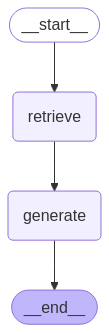

In [62]:
from langchain import hub
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

## Prompt - predefined
prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)


## Prompt - custom
template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use five sentences maximum and keep the answer as concise as possible.
Always start the answer with a sentence like "Thanks for asking question about North Light AI!"; but be innovative and each time use a similar welcoming message.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

## State
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

## Nodes
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

## Control flow


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

# Visualize the graph
display(Image(graph.get_graph().draw_mermaid_png()))

### Usage

In [65]:
result = graph.invoke({"question": "Who is Dr. Roozbeh Ghasemi?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(metadata={'source': 'https://northlightai.com/our-team', 'website': 'https://northlightai.com', 'company_id': '8de75db1-323c-4bf4-8693-05a657d3a474'}, page_content="of expertise in data analytics, business intelligence, and AI-driven decision-making. With an extensive academic background and professional experience, Dr. Gwebu has dedicated his career to helping organizations harness the power of data and AI to drive innovation and operational efficiency. At North Light AI, he plays a key role in designing and delivering impactful AI solutions and training programs that empower businesses and individuals to thrive in the digital age. Dr. Gwebu's commitment to ethical AI and practical applications ensures that the technology is both transformative and responsible. Show Less Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi is a multidisciplinary researcher and Ph.D.

### Stream steps and tokens

In [59]:
for step in graph.stream(
    {"question": "Who is Dr. Roozbeh Ghasemi?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

for message, metadata in graph.stream(
    {"question": "Who is Dr. Roozbeh Ghasemi?"}, stream_mode="messages"
):
    print(message.content, end="|")

{'retrieve': {'context': [Document(metadata={'source': 'https://northlightai.com/our-team', 'website': 'https://northlightai.com', 'company_id': '8de75db1-323c-4bf4-8693-05a657d3a474'}, page_content="of expertise in data analytics, business intelligence, and AI-driven decision-making. With an extensive academic background and professional experience, Dr. Gwebu has dedicated his career to helping organizations harness the power of data and AI to drive innovation and operational efficiency. At North Light AI, he plays a key role in designing and delivering impactful AI solutions and training programs that empower businesses and individuals to thrive in the digital age. Dr. Gwebu's commitment to ethical AI and practical applications ensures that the technology is both transformative and responsible. Show Less Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi - Lead Data & AI Analyst Dr. Roozbeh Ghasemi is a multidisciplinary rese